In [1]:
import numpy as np
from numpy.matlib import repmat
import pandas as pd
import scipy.stats as stats
from statsmodels.stats import multitest
import sys
sys.path.insert(1, "../utilities")
from plot_utils import *
from reliability import *
from n_effective import *
from VAT_simple import *
from MWSL import *
from correlation_test import *
LINEMARK = '---------------------------------------------------------------------------------------'

In [2]:
def save_ttest(featureInfo, p_FDR, p_uncorrected, fc, minmargin, significant, patterns, pattern_inds, countsX, countsY, fname_out, header=None):
    
    # add a header to the output file if one is not provided    
    if header is None:
        header = " compound; masstime; test; p_orig; p_FDR; p_Bonf; FC; ms; gaps1; gaps2\n"
    # add ".csv" to the end of the filename if it's not already there
    if fname_out[-4:] != '.csv':
        fname_out += '.csv'
    p_Bonf = p_uncorrected * len(p_uncorrected)
    p_Bonf[p_Bonf>1] = 1
    # write the header
    i=0
    with open(fname_out, 'w') as f:
        f.write(header)
        while i < len(p_uncorrected):
            if significant[i]:
                # write the above in oneline
                f.write('%s;%s@%s;%s;%f;%f;%f;%f;%f;%d;%d\n' % (featureInfo[i,0],\
                                                                featureInfo[i,4],\
                                                                featureInfo[i,5],\
                                                                patterns[pattern_inds[i]],\
                                                                p_uncorrected[i],\
                                                                p_FDR[i],\
                                                                p_Bonf[i],\
                                                                fc[i],\
                                                                minmargin[i],\
                                                                countsX[i],\
                                                                countsY[i]))
            i+=1

    f.close()
    

In [2]:
path = '../../../PARKINSONS/PDproj/celldata/datawithGFstatus/clean/'
filenames = [line.rstrip() for line in open(path +'filenames.txt')]
filenames

['cellshilicnegGFstatus.csv',
 'cellshilicposGFstatus.csv',
 'cellslipidnegGFstatus.csv',
 'cellslipidposGFstatus.csv',
 'cellsRPnegGFstatus.csv',
 'cellsRPposGFstatus.csv',
 'mediumhilicnegGFstatus.csv',
 'mediumhilicposGFstatus.csv',
 'mediumRPnegGFstatus.csv',
 'mediumRPposGFstatus.csv']

In [3]:
# SET FILE NUMBER and FILE NAME
fnum=0
fname = filenames[fnum].split('GF')[0]

# SET PARAMETERS
ALPHA=0.05

KEEP_ALL=False # whether to keep all results or just those with FC > MINFC
MINFC=1.5

MINVAR=0.25
PRUNE=True # drop tests with one or both tests having the number of un-acceptable values above tol

tol = 0.8
accept = [0, 8, 64, 128]

# SAVE (MANUAL SWITCH'S)
SAVE=False
KEEP_INSIGNIFICANT=False # keeps all p values not just significant

FOLDER_OUT = './results/'

if KEEP_ALL:
    FNAME_OUT = FOLDER_OUT + fname + "ALPHA" + str(ALPHA) + "MINVAR" + str(MINVAR) + ".csv"
else:
    FNAME_OUT = FOLDER_OUT + fname + "ALPHA" + str(ALPHA) + "FC" + str(MINFC) + "MINVAR" + str(MINVAR) + ".csv"
    
# Print parameters
print(LINEMARK)
print("FILENAME: ", fname)
if SAVE:
    print("SAVING TO: ", FNAME_OUT)
print('\nPARAMETERS:')
print('ALPHA =', ALPHA)
print('KEEP_ALL =', KEEP_ALL)
print('MINFC =', MINFC)
print('MINVAR =', MINVAR)
print('PRUNE =', PRUNE)
print('SAVE =', SAVE)
print('KEEP_INSIGNIFICANT =', KEEP_INSIGNIFICANT)

---------------------------------------------------------------------------------------
FILENAME:  cellshilicneg

PARAMETERS:
ALPHA = 0.05
KEEP_ALL = False
MINFC = 1.5
MINVAR = 0.25
PRUNE = True
SAVE = False
KEEP_INSIGNIFICANT = False


In [4]:
# SET FILE NUMBER and FILE NAME
fnum=0
fname = filenames[fnum].split('GF')[0]

# SET PARAMETERS
ALPHA=0.05

KEEP_ALL=False # whether to keep all results or just those with FC > MINFC
MINFC=1.5

MINVAR=0.25
PRUNE=True # drop tests with one or both tests having the number of un-acceptable values above tol

tol = 0.8
accept = [0, 8, 64, 128]

# SAVE (MANUAL SWITCH'S)
SAVE=False
KEEP_INSIGNIFICANT=False # keeps all p values not just significant

FOLDER_OUT = './results/'

if KEEP_ALL:
    FNAME_OUT = FOLDER_OUT + fname + "ALPHA" + str(ALPHA) + "MINVAR" + str(MINVAR) + ".csv"
else:
    FNAME_OUT = FOLDER_OUT + fname + "ALPHA" + str(ALPHA) + "FC" + str(MINFC) + "MINVAR" + str(MINVAR) + ".csv"
    
##########################################################################################

# READ THE DATA
df = pd.read_csv(path + filenames[fnum],sep=';', header=None)

patterns = ["aSYN--UT", "comb.--UT", "INFg--UT", "aSYN--INFg","comb.--INFg.", "aSYN--comb."]
n_patterns = len(patterns)


# Compile the data for testing
AREA = df.iloc[3:,8:48].to_numpy(dtype=float)
GROUPS = df.iloc[0,8:48].to_numpy(dtype=str)
GAP = df.iloc[3:,88:].to_numpy(dtype=int)
FEATURE_INFO = df.iloc[3:,:8].to_numpy(dtype=str)
n_tests_init = AREA.shape[0]*n_patterns
n_features_init = AREA.shape[0]

# APPLY THE VARIANCE FILTER TO BOTH AREA AND GAP data
# and update the feature info (account dropped features)
variance = np.var(AREA, axis=1, ddof=1)
AREA = AREA[variance >= MINVAR,:]
GAP = GAP[variance >= MINVAR,:]
FEATURE_INFO = FEATURE_INFO[variance >= MINVAR,:]
variance = variance[variance >= MINVAR][:,np.newaxis]
n_tests_after_var = AREA.shape[0]*n_patterns
n_features_after_var = AREA.shape[0]

# Compile test identifiers, that map test/row to test identifier string (for possible later use)
I = np.ones((AREA.shape[0],1), dtype=int)
pattern_inds = np.vstack((0*I, 1*I, 2*I, 3*I, 4*I, 5*I)).flatten()
#  and expand the variance and info to match the testsize (for possible later use)
FULL_VARIANCE = repmat(variance, n_patterns, 1)
FULL_FEATURE_INFO = repmat(FEATURE_INFO, n_patterns, 1)

# Compile the data for testing
aSYN = AREA[:,0:10]
comb = AREA[:,10:20]
IFNg = AREA[:,20:30]
UT = AREA[:,30:40]

dataX = np.vstack((aSYN, comb, IFNg, aSYN, comb, aSYN))
dataY = np.vstack((UT,   UT,   UT,   IFNg, IFNg, comb))

GAP_aSYN = GAP[:,0:10]
GAP_comb = GAP[:,10:20]
GAP_IFNg = GAP[:,20:30]
GAP_UT = GAP[:,30:40]

gapX = np.vstack((GAP_aSYN, GAP_comb, GAP_IFNg, GAP_aSYN, GAP_comb, GAP_aSYN))
gapY = np.vstack((GAP_UT,   GAP_UT,   GAP_UT,   GAP_IFNg, GAP_IFNg, GAP_comb))

keep, countX, countY = reliability(gapX, gapY, tol=0.8, accept=[0, 8, 64, 128])
n_tests_after_reliability = np.sum(keep)
if PRUNE:
    # Keep only the reliable tests
    dataX=dataX[keep,:]
    dataY=dataY[keep,:]
    
    # same for other information (variance not used at the moment)
    FULL_VARIANCE=FULL_VARIANCE[keep]
    FULL_FEATURE_INFO=FULL_FEATURE_INFO[keep,:]
    pattern_inds=pattern_inds[keep]
    countX=countX[keep]
    countY=countY[keep]

# Calculate the fold-change and positive minmargin (note: data is already log transformed)
fc = dataX.mean(axis=1) - dataY.mean(axis=1)
minmargin = np.max(np.stack((np.nanmin(dataX, axis=1) - np.nanmax(dataY, axis=1),np.nanmin(dataY, axis=1) - np.nanmax(dataX, axis=1)),axis=1), axis=1)
minmargin = np.clip(minmargin, 0, None)
result = stats.ttest_ind(dataX, dataY, axis=1, equal_var=False, nan_policy='raise')
p_uncorrected = result.pvalue

################################################################################################

multitest_method = 'fdr_by'
rejected, p_corrected, alphacSidak, alphacBonf = multitest.multipletests(p_uncorrected, alpha=ALPHA, method=multitest_method)

print("FILENAME: ", fname)
print('\nPARAMETERS:')
print('ALPHA =', ALPHA)
print('KEEP_ALL =', KEEP_ALL)
print('MINFC =', MINFC)
print('MINVAR =', MINVAR)
print('PRUNE =', PRUNE)
# Print the number of tests after pruning
print('\nRESULTS:')
print("Number of tests before pruning: ", n_tests_init)
print("Number of tests after variance filtering: ", n_tests_after_var)
print("Number of tests after pruning based on missing values (code 32): ", dataX.shape[0])
print("Number of features initially: ", n_features_init)
print("Number of features after variance filtering: ", n_features_after_var)
print("Number of tested features (after filtering and pruning based on reliability): ", int(np.ceil(dataX.shape[0]/n_patterns)))
print(LINEMARK)
print("Number of discoveries with uncorrected p-values: ", np.sum(p_uncorrected <= ALPHA))
print("Number of discoveries with B-Y corrected p-values: ", np.sum(p_corrected <= ALPHA))
#print("Number of discoveries based on Sidak correction: ", np.sum(p_uncorrected <= alphacSidak))
print("Number of discoveries based on Bonferroni correction: ", np.sum(p_uncorrected <= alphacBonf))
print("Number of discoveries with B-Y corrected p-values and |FC| >=", MINFC, ": ", np.sum((p_corrected <= ALPHA) & (np.abs(fc) >= MINFC)))
print("Number of discoveries with B-Y corrected p-values and minmargin > 0 :", np.sum((minmargin > 0) & (p_corrected <= ALPHA)))
print("Number of discoveries with B-Y corrected p-values, |FC| >= {}, and minmargin > 0 :".format(MINFC), np.sum((minmargin > 0) & (p_corrected <= ALPHA) & (np.abs(fc) >= MINFC)))
print("Number of tests with |FC| >= ", MINFC, ": ", np.sum(np.abs(fc) >= MINFC))
print("Number of tests with minmargin > 0: ", np.sum(minmargin > 0))
print(LINEMARK)

FILENAME:  cellshilicneg

PARAMETERS:
ALPHA = 0.05
KEEP_ALL = False
MINFC = 1.5
MINVAR = 0.25
PRUNE = True

RESULTS:
Number of tests before pruning:  786
Number of tests after variance filtering:  534
Number of tests after pruning based on missing values (code 32):  469
Number of features initially:  131
Number of features after variance filtering:  89
Number of tested features (after filtering and pruning based on reliability):  79
---------------------------------------------------------------------------------------
Number of discoveries with uncorrected p-values:  79
Number of discoveries with B-Y corrected p-values:  18
Number of discoveries based on Bonferroni correction:  14
Number of discoveries with B-Y corrected p-values and |FC| >= 1.5 :  2
Number of discoveries with B-Y corrected p-values and minmargin > 0 : 7
Number of discoveries with B-Y corrected p-values, |FC| >= 1.5, and minmargin > 0 : 1
Number of tests with |FC| >=  1.5 :  6
Number of tests with minmargin > 0:  8
--

In [5]:
# Pick the index of the first non-rejected test from sorted list
p_correctedsorted_inds=np.argsort(p_corrected)
p_uncorrectedsorted=p_uncorrected[p_correctedsorted_inds]
rejected_sorted=rejected[p_correctedsorted_inds]
first_non_rejected = np.argmin(rejected_sorted)
print("(uncorrected) P value of the last B-Y significant test: %.8f" % p_uncorrectedsorted[first_non_rejected-1], end=' ')
print("(FDR corrected %.4f)" % p_corrected[p_correctedsorted_inds[first_non_rejected-1]])
print("(uncorrected) P value of the first B-Y non-significant test: %.8f" % p_uncorrectedsorted[first_non_rejected], end=' ')
print("(FDR corrected %.4f)" % p_corrected[p_correctedsorted_inds[first_non_rejected]])
print("Alpha Sidak: %.8f" % alphacSidak)
print("Alpha Bonferroni: %.8f" % alphacBonf)
print(LINEMARK)

(uncorrected) P value of the last B-Y significant test: 0.00028267 (FDR corrected 0.0496)
(uncorrected) P value of the first B-Y non-significant test: 0.00041922 (FDR corrected 0.0696)
Alpha Sidak: 0.00010936
Alpha Bonferroni: 0.00010661
---------------------------------------------------------------------------------------


In [6]:
# Save the results
if SAVE:
    if KEEP_INSIGNIFICANT:
        report = np.ones(p_corrected.shape, dtype=bool)
    elif KEEP_ALL:
        report = rejected
    else:
        report = (rejected & (np.abs(fc) >= MINFC))
    save_ttest(FULL_FEATURE_INFO, p_corrected, p_uncorrected, fc, minmargin, report, patterns, pattern_inds, countX, countY, FNAME_OUT)
    print("Saved the results to: ", FNAME_OUT)
else:
    print("Results not saved.")

Results not saved.


### Inspect the data to probe the effective number of (independent) tests

#### First, calculate correlations and determine if they are statistically significant

In [7]:
result_correlation_test = test_correlation_parallel(AREA, alpha=0.05, keep_dims=False)

Running on 16 cores

Time elapsed:  4.193765163421631


In [8]:
fdr_mask = result_correlation_test['p_FDR'] <= 0.05
bonferroni_mask = result_correlation_test['pvalues'] <= result_correlation_test['alphacBonf']

In [9]:
result_confidence_interval = confidence_interval_correlation(np.corrcoef(AREA), alpha=0.05, threshold=0.95)
cor_vector = result_confidence_interval['cor_vector']
CI_mask_vector = result_confidence_interval['CI_mask_vector']

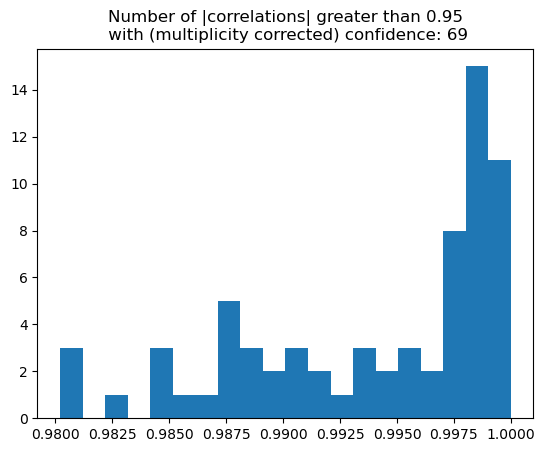

In [15]:
# Plot the correlation matrix
#plt.hist(cor_vector)
plt.hist(cor_vector[CI_mask_vector], bins=20)
# as a title, put the number of significant correlations
plt.title("Number of |correlations| greater than 0.95\n with (multiplicity corrected) confidence: {}".format(np.sum(CI_mask_vector)))
plt.show()

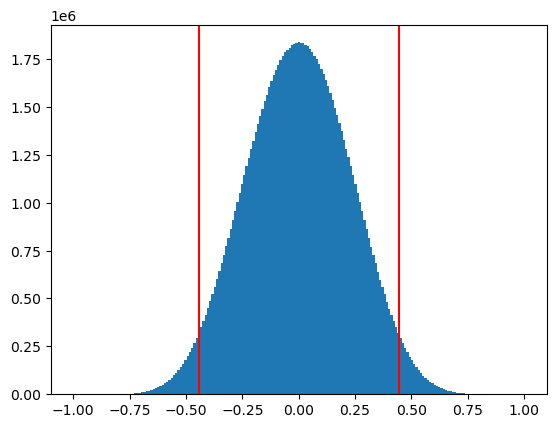

In [16]:
bins=np.linspace(-1,1,200)
it = 1000
data = np.hstack((dataX, dataY))
all_correlations = np.zeros((it, data.shape[0]*(data.shape[0]-1)//2))
for i in range(it):
    random_data = np.zeros(data.shape)
    for j in range(data.shape[0]):
        random_inds = np.random.permutation(20)
        random_data[j,:] = data[j,random_inds]
    correlations = np.corrcoef(random_data)
    all_correlations[i,:] = correlations[np.triu_indices(data.shape[0], k=1)]
    
# plot the histogram of correlations
plt.hist(all_correlations.reshape(-1), bins=bins)
# plot vertical lines for the 95% confidence interval
CI_lower = np.quantile(all_correlations, 0.025)
CI_upper = np.quantile(all_correlations, 0.975)
plt.axvline(x=CI_lower, color='r')
plt.axvline(x=CI_upper, color='r')
plt.show()

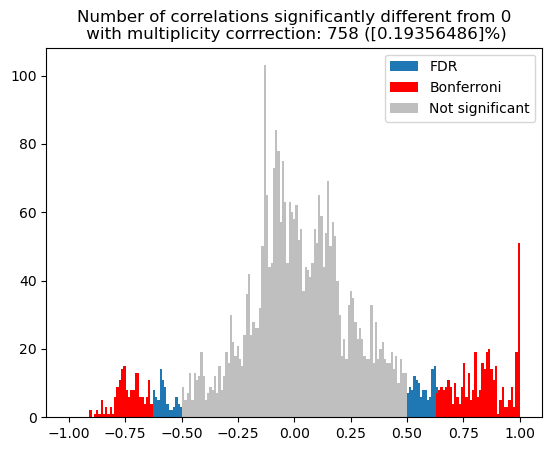

In [22]:
bins=np.linspace(-1,1,200)
plt.hist(result_correlation_test['corrcoef'][fdr_mask], bins=bins)
plt.hist(result_correlation_test['corrcoef'][bonferroni_mask], bins=bins, color='r')
plt.hist(result_correlation_test['corrcoef'][~fdr_mask], bins=bins, color='gray', alpha=0.5)
# add color explanation
plt.legend(['FDR', 'Bonferroni', 'Not significant'])
# add title to explain the number of significant correlations (significantly different from 0)
plt.title("Number of correlations significantly different from 0\n with multiplicity corrrection: {} ({}%)".format(np.sum(fdr_mask),
                                                                                                             np.sum(fdr_mask)/result_correlation_test['corrcoef'].shape))
plt.show()

### Clustering based on correlations

In [23]:
X_std = StandardScaler().fit_transform(AREA.T).T
cov_mat =np.cov(X_std, ddof=0)
COR = np.cov(X_std, ddof=0)

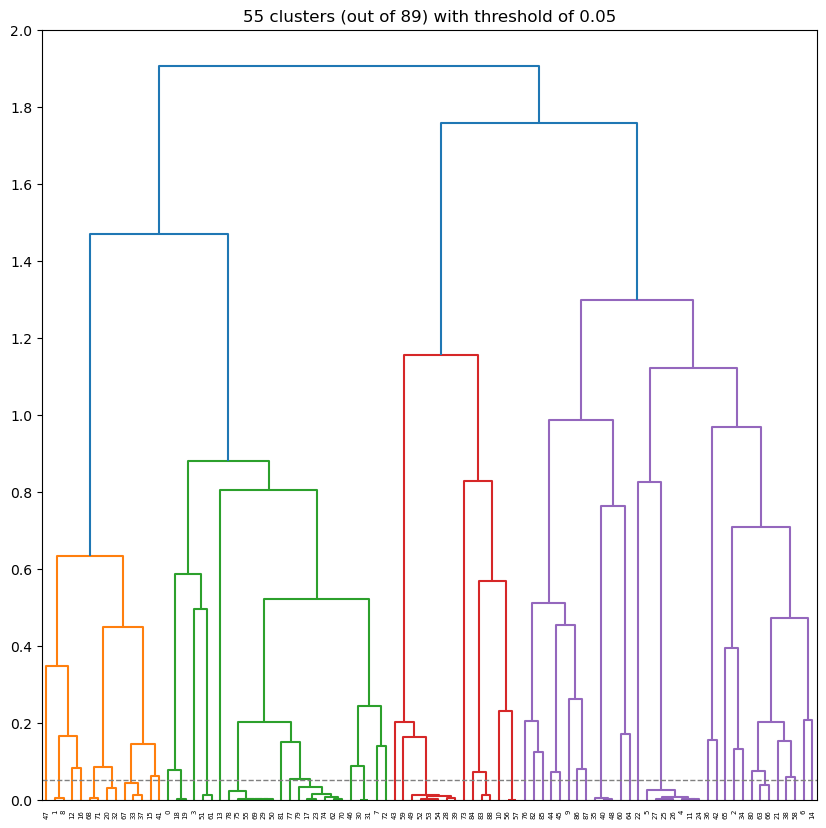

In [27]:
plt.figure(figsize=(10,10))
result_hierarchical = n_eff_cluster(COR, threshold = 0.05, alpha=0.05, method = 'complete', plot = True, return_labels = True, factor = 1) 

#### Get the M_eff and corrected significance level from the results

In [28]:
M_eff = result_hierarchical['M_eff']
alpha_Bonf = result_hierarchical['Bonferroni']
alpha_Sidak = result_hierarchical['Sidak']
print("Effective number of features: ", M_eff)
print("Effective number of tests: ", M_eff*n_patterns)
print("Bonferroni corrected significance level: %.8f" % alpha_Bonf)
print("Sidak corrected significance level: %.8f" % alpha_Sidak)
print(LINEMARK)

Effective number of features:  55
Effective number of tests:  330
Bonferroni corrected significance level: 0.00090909
Sidak corrected significance level: 0.00093217
---------------------------------------------------------------------------------------


## M_eff estimation technique 1

**Adjusting multiple testing in multilocus analyses using the eigenvalues of a correlation matrix**

https://www.nature.com/articles/6800717

$f(X) = I(x\geq0)  + (x - floor(x)), x>0$

In [29]:
f = lambda x: int(x>=1) + x - np.floor(x)
eigvals = np.real(np.linalg.eig(cov_mat)[0])
M_eff1 = np.sum([f(elem) for elem in eigvals])

In [30]:
print("Effective number of tests: ", M_eff1)
print("Sidak alpha: %.8f" % (1-(1-ALPHA)**(1/COR.shape[0])))
print("Sidak alpha with M_eff: %.8f" %  (1-(1-ALPHA)**(1/M_eff1)))
print("Bonferroni alpha: %.8f" % (ALPHA/cov_mat.shape[0]))
print("Bonferroni alpha with M_eff: %.8f" % (ALPHA/M_eff1))

Effective number of tests:  49.00000000000004
Sidak alpha: 0.00057616
Sidak alpha with M_eff: 0.00104625
Bonferroni alpha: 0.00056180
Bonferroni alpha with M_eff: 0.00102041


In [31]:
print("Bonferroni alpha with all features: %.8f" % (ALPHA/cov_mat.shape[0]))
print("Bonferroni alpha with M_eff: %.8f" % (ALPHA/M_eff1))

Bonferroni alpha with all features: 0.00056180
Bonferroni alpha with M_eff: 0.00102041


## M_eff estimation technique 2

**Cheverud (2001)**

$V(\lambda) = \sum_{i=1}^{M}(\lambda_i - 1)^2/(M-1)$

In [32]:
V = lambda λ: 1/(len(λ)-1)*(λ-1)@(λ-1)
M_eff2 = 1 + (len(eigvals)-1)*(1-V(eigvals)/len(eigvals))

In [33]:
print("Effective number of tests: ", M_eff2)
print("Sidak alpha: %.8f" % (1-(1-ALPHA)**(1/cov_mat.shape[0])))
print("Sidak alpha with M_eff: %.8f" %  (1-(1-ALPHA)**(1/M_eff2)))

Effective number of tests:  76.00464655656293
Sidak alpha: 0.00057616
Sidak alpha with M_eff: 0.00067464


In [34]:
print("Bonferroni alpha with all features: %.8f" % (ALPHA/cov_mat.shape[0]))
print("Bonferroni alpha with M_eff: %.8f" % (ALPHA/M_eff2))

Bonferroni alpha with all features: 0.00056180
Bonferroni alpha with M_eff: 0.00065785


### Other techniques

 https://www.nature.com/articles/6889010

In [356]:
M = len(eigvals)
M_eff3 = M*(1 - (M - 1)*np.var(eigvals) / M**2)
M_eff3

90.73740666442747

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1181954/

In [357]:
M_eff4 = 1 + (M - 1)*(1 - np.var(eigvals) / M)
M_eff4

90.73740666442747

https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-021-03975-2

In [35]:

def MWSL_parallel(dataX, dataY, alpha = 0.05, K = None):
    """
    from https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-021-03975-2
    
    MWSL: Metabolome-Wide Significance Level
    Solves the multiple testing problem by permutation testing.
    Accounts for the correlation between the tests by permuting the labels of the samples.
    
    Idea:
    • Step (1): Shuffle i.e. re-sample without replacement, the outcome variable Y.
    In this way, the n subjects are re-sampled under the null hypothesis of no association.
    
    • Step (2): To estimate the relationship between the outcome and the set of features
    while accounting for possible confounding effects, run M t-tests.
    
    • Step (3): Extract the minimum of the set of M p values as this indicates the highest
    threshold value which would reject all M null hypotheses.
    
    • Step (4): Repeat Step (1)-(3) for K times, where K is at least n/2 times M. The K
    minimum p values are the elements of the new vector q.
    
    • Step (5): Sort the elements of q, and take the ( alpha*K)-value of this vector. This value
    is the MWSL estimate. An approximate confidence interval can be obtained by
    treating the true position of the MWSL estimate as a Binomial random variable
    with parameters K and alpha . Then, using the Normal approximation to the Binomial,
    we obtain the z_(1-alpha)% confidence limits by extracting the elements of q in positions
    (alpha*K) ± (1 - alpha)*sqrt(alpha*K(1 - alpha).
    
    • Step (6): Compute the effective number of tests (ENT) defined as the number of
    independent tests that would be required to obtain the same significance level using
    the Bonferroni correction ENT = alpha/MWSL . The ENT estimate measures the extent that
    the M markers are non-redundant. Therefore, the ratio R = ENT/M % of the effective
    and the actual number of tests (ANT or M) is a measure of the dependence among
    features, which is expected to be closer to 0% when highly correlated features are
    considered
    
    X: data matrix
    K: number of permutations
    alpha: significance level
    """
    assert alpha > 0 and alpha < 1, "alpha must be between 0 and 1"
    assert dataX.shape[0] == dataY.shape[0], "dataX and dataY must have the same number of rows"
    
    data = np.hstack((dataX, dataY))
    nX = dataX.shape[1]
    n=data.shape[1]
    M=data.shape[0]
    
    if K is None:
        K = int(np.ceil(n/2*M))
        print("K not specified, using K = n/2*M = ", K)
    else:
        assert K > n/2*M, "K must be greater than n/2*M"
    
    q=np.zeros(K)
    all_pvalues = np.zeros((K, M))
    
    # parallel processing
    start = time.time()
    num_cores = multiprocessing.cpu_count()
    print("Running on {} cores".format(num_cores))
    
    # Generate the random indices
    rand_inds = np.stack([np.random.permutation(n) for i in range(K)], axis=0)
    results = Parallel(n_jobs=num_cores)(delayed(stats.ttest_ind)(data[:,rand_inds[i,:nX]],\
                                                                    data[:,rand_inds[i,nX:]],\
                                                                        axis=1, equal_var=False, nan_policy='raise') for i in range(K))
    
    
    q = np.asarray([np.min(result.pvalue) for result in results])
    all_pvalues = np.asarray([result.pvalue for result in results])
    
    q.sort()
    MWSL = q[int(alpha*K)]
    ENT = alpha/MWSL
    R = ENT/M
    MWSL_CI = (q[int(alpha*K - 1 - (1 - alpha)*np.sqrt(alpha*K*(1 - alpha)))], q[int(alpha*K - 1 + (1 - alpha)*np.sqrt(alpha*K*(1 - alpha)))])
    
    # make a dictionary with the results
    result = {}
    result['MWSL'] = MWSL
    result['ENT'] = ENT
    result['R'] = R
    result['MWSL_CI'] = MWSL_CI
    result['all_pvalues'] = all_pvalues
    
    end = time.time()
    print("Time elapsed: ", end-start)
    
    return result


In [32]:
# generate random data like the original dataX and dataY
random_dataX = np.random.normal(size=dataX.shape)
random_dataY = np.random.normal(size=dataY.shape)

Running on 16 cores
Time elapsed:  35.26506495475769
MWSL: 0.00036603
ENT: 136.60033811
R: 0.29125872
MWSL CI: (0.00036218, 0.00037152)


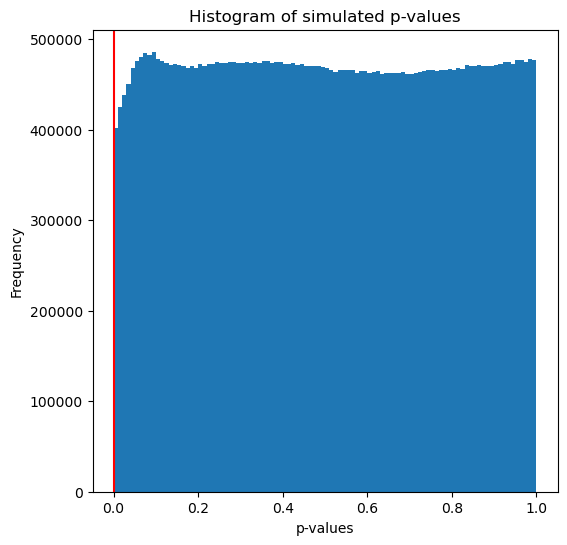

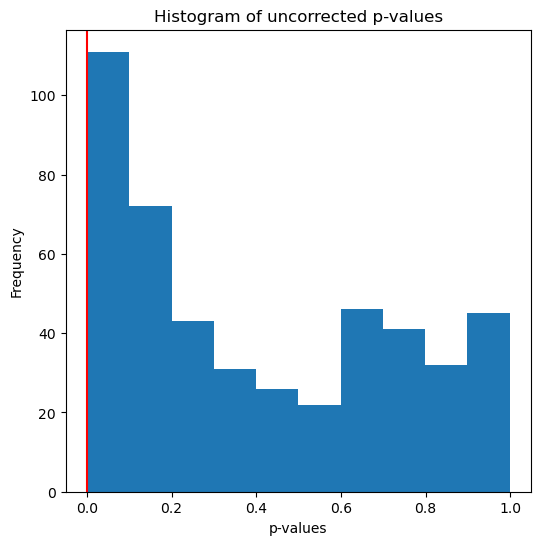

In [58]:
result_MWSL = MWSL_parallel(dataX, dataY, alpha = 0.05, K=int(10e4))
print("MWSL: %.8f" % result_MWSL['MWSL'])
print("ENT: %.8f" % result_MWSL['ENT'])
print("R: %.8f" % result_MWSL['R'])
print("MWSL CI: (%.8f, %.8f)" % (result_MWSL['MWSL_CI'][0], result_MWSL['MWSL_CI'][1]))
plt.figure(figsize=(6,6))
plt.hist(result_MWSL['all_pvalues'].flatten(), bins = 100)
plt.axvline(result_MWSL['MWSL'], color = 'red')
plt.xlabel('p-values')
plt.ylabel('Frequency')
plt.title('Histogram of simulated p-values')
plt.show()
# plot the uncorrected p-values
plt.figure(figsize=(6,6))
plt.hist(p_uncorrected, bins = 10)
plt.axvline(result_MWSL['MWSL'], color = 'red')
plt.xlabel('p-values')
plt.ylabel('Frequency')
plt.title('Histogram of uncorrected p-values')
plt.show()

(array([ 9710.,  9942.,  9847.,  9857.,  9834., 10154., 10185., 10063.,
        10057., 10351.]),
 array([6.14651656e-06, 1.00005451e-01, 2.00004755e-01, 3.00004059e-01,
        4.00003363e-01, 5.00002668e-01, 6.00001972e-01, 7.00001276e-01,
        8.00000580e-01, 8.99999885e-01, 9.99999189e-01]),
 <BarContainer object of 10 artists>)

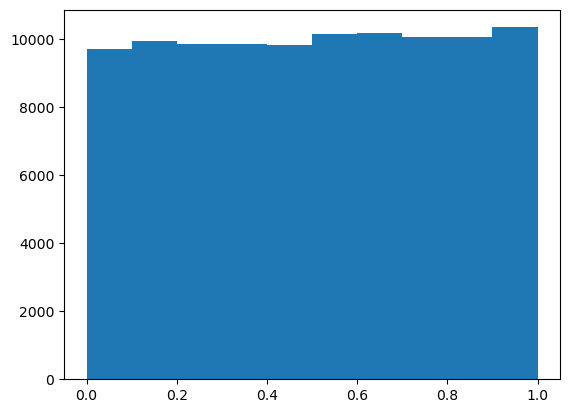

In [69]:
plt.hist(result_MWSL['all_pvalues'][:,15])

In [94]:
print("Number of discoveries with MWSL: ", np.sum(p_uncorrected < result_MWSL['MWSL']))
print("Number of discoveries with B-Y corrected p-values: ", np.sum(p_corrected < ALPHA))
print("Number of discoveries based on Sidak correction: ", np.sum(p_uncorrected < alphacSidak))
print("Number of discoveries based on Bonferroni correction: ", np.sum(p_uncorrected < alphacBonf)) 

Number of discoveries with MWSL:  18
Number of discoveries with B-Y corrected p-values:  18
Number of discoveries based on Sidak correction:  14
Number of discoveries based on Bonferroni correction:  14


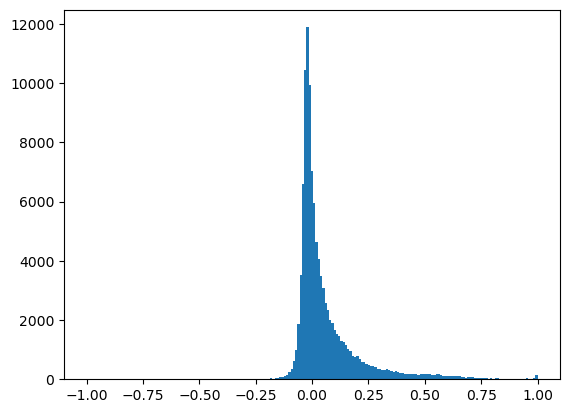

In [95]:
pval_cor = np.corrcoef(result_MWSL['all_pvalues'].T)
pval_cor = pval_cor[np.triu_indices(pval_cor.shape[0], k=1)]
plt.hist(pval_cor, bins=bins)
plt.show()

K not specified, using K = n/2*M =  4690
Running on 16 cores
Time elapsed:  6.650500297546387
MWSL: 0.00009744
ENT: 513.12517357
R: 1.09408353
MWSL CI: (0.00008816, 0.00010248)


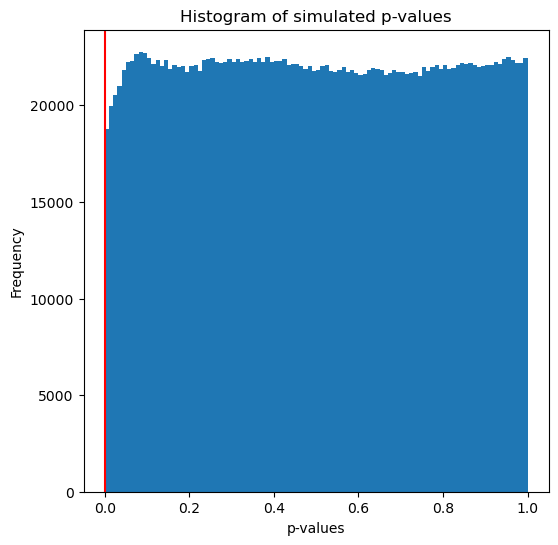

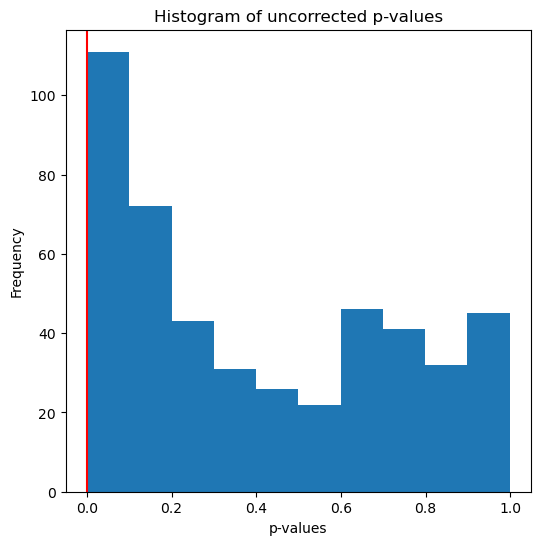

In [96]:
# do the same with parallel processing
result_MWSL_parallel = MWSL_independent_parallel(dataX, dataY, alpha = 0.05)
print("MWSL: %.8f" % result_MWSL_parallel['MWSL'])
print("ENT: %.8f" % result_MWSL_parallel['ENT'])
print("R: %.8f" % result_MWSL_parallel['R'])
print("MWSL CI: (%.8f, %.8f)" % (result_MWSL_parallel['MWSL_CI'][0], result_MWSL_parallel['MWSL_CI'][1]))
plt.figure(figsize=(6,6))
plt.hist(result_MWSL_parallel['all_pvalues'].flatten(), bins = 100)
plt.axvline(result_MWSL_parallel['MWSL'], color = 'red')
plt.xlabel('p-values')
plt.ylabel('Frequency')
plt.title('Histogram of simulated p-values')
plt.show()

# plot the uncorrected p-values
plt.figure(figsize=(6,6))
plt.hist(p_uncorrected, bins = 10)
plt.axvline(result_MWSL_parallel['MWSL'], color = 'red')
plt.xlabel('p-values')
plt.ylabel('Frequency')
plt.title('Histogram of uncorrected p-values')
plt.show()

In [97]:
print("Number of discoveries with MWSL: ", np.sum(p_uncorrected < result_MWSL_parallel['MWSL']))
print("Number of discoveries with B-Y corrected p-values: ", np.sum(p_corrected < ALPHA))
print("Number of discoveries based on Sidak correction: ", np.sum(p_uncorrected < alphacSidak))
print("Number of discoveries based on Bonferroni correction: ", np.sum(p_uncorrected < alphacBonf)) 

Number of discoveries with MWSL:  13
Number of discoveries with B-Y corrected p-values:  18
Number of discoveries based on Sidak correction:  14
Number of discoveries based on Bonferroni correction:  14


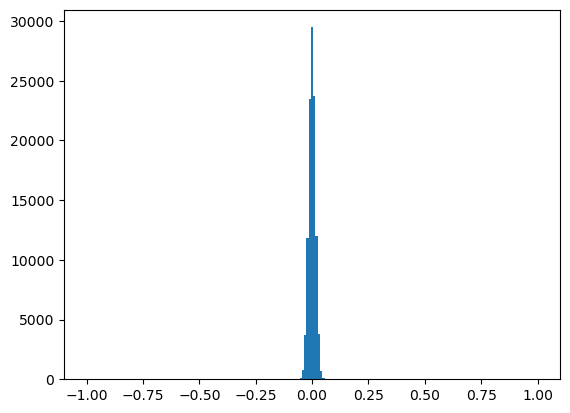

In [98]:
pval_cor = np.corrcoef(result_MWSL_parallel['all_pvalues'].T)
pval_cor = pval_cor[np.triu_indices(pval_cor.shape[0], k=1)]
plt.hist(pval_cor, bins=bins)
plt.show()